In [1]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [2]:
outdict = readinput("chem300.rms")


[16:15:50] WARNING: not removing hydrogen atom without neighbors
[16:15:50] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-Electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [3]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [4]:
sitedensity = 2.292e-5 # Ag111
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [5]:
initialcondsliq = Dict(["proton"=>10.0^-4,
        "CO2"=>10.0^-3*10^6,
        "V"=>1.0,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
AVratio = 1.0e5
initialcondssurf = Dict(["CO2X"=>0.4*sitedensity*AVratio,
        "CHO2X"=>0.1*sitedensity*AVratio,
        "CO2HX"=>0.1*sitedensity*AVratio,
        "OX"=>0.1*sitedensity*AVratio,
        "OCX"=>0.1*sitedensity*AVratio,
        "vacantX"=>0.1*sitedensity*AVratio,
        "CH2O2X"=>0.05*sitedensity*AVratio,
        "CHOX"=>0.04*sitedensity*AVratio,
        "CH2OX"=>0.01*sitedensity*AVratio,
        "A"=>1.0*AVratio,"T"=>300,"Phi"=>-1.5]);

In [6]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [7]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [8]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0e1), [inter], (pliq,pcat,pinter));


 29.632929 seconds (51.14 M allocations: 3.180 GiB, 9.55% gc time, 99.12% compilation time: <1% of which was recompilation)


In [9]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-6);

 16.144382 seconds (21.05 M allocations: 8.569 GiB, 8.44% gc time, 55.82% compilation time)


In [10]:
sol

retcode: Success
Interpolation: 3rd order Hermite
t: 3904-element Vector{Float64}:
  0.0
  1.789980841616402e-20
  6.576900249013983e-20
  2.5030197422085537e-19
  4.348349459515709e-19
  6.193679176822864e-19
  9.084319853878446e-19
  1.3872833260142728e-18
  2.2045875289611035e-18
  3.6004836914895165e-18
  ⋮
  9.189788168155644
  9.2370593941606
  9.284330620165555
  9.374450952733241
  9.513199200877803
  9.651947449022366
  9.790695697166928
  9.92944394531149
 10.0
u: 3904-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0001, 9.877435240096272e-151, 1.639742938192689e-19, 6.105959620100551e-20, 1.0256590222442697e-14  …  5.857762549895438e-47, 3.710519968228952e-74, 1.6680785314922016e-93, 1.0063687095654829e-174, 3.7275896533124676e-80, 3.613007473974726e-94, 3.0304066208769977e-71, 1.1889769427868552e-139, 4.07542553574799e-46, 2.9372895926250776e-67]


In [11]:
sol.retcode

ReturnCode.Success = 1

In [12]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [ ]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

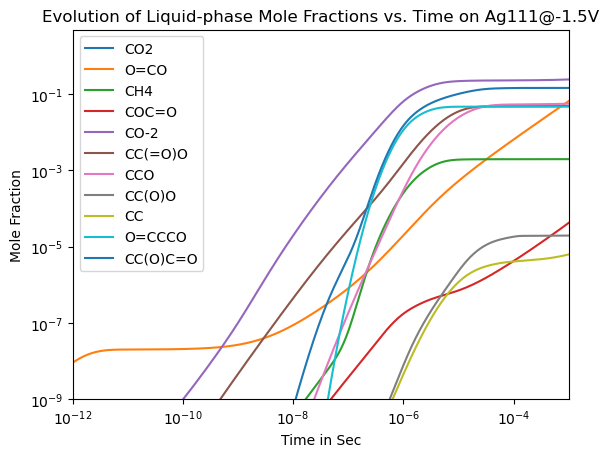

In [34]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-3, 10, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e-3)
ylim(1e-9, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

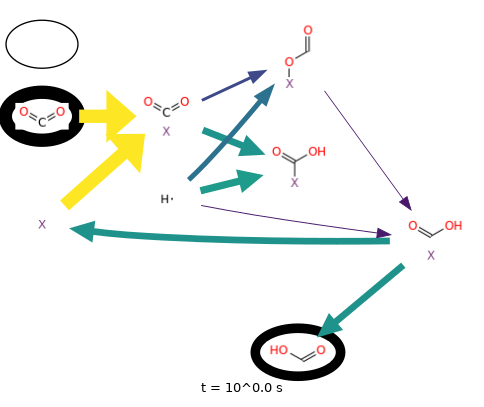

In [15]:
getfluxdiagram(ssys,1;speciesratetolerance=0.4)

In [16]:
println(ssys.names)

["Ar", "He", "Ne", "N2", "CO2", "proton", "H", "C=O", "O=CO", "H2O", "O=CC=O", "H2", "OO", "CO", "O2", "O=C=C=O", "C=C=O", "O=C=CO", "CH4", "COC=O", "COO", "CO-2", "COOC", "O=CCO", "OCO", "COCO", "OCCO", "OC=CO", "O=O", "C=CO", "C=C", "O=C=C=C=O", "C#COO[CH2]", "C#COC[O]", "CC=O", "O=C=CC=O", "C=C(O)O", "CC(=O)O", "[OH]", "CC(=O)C=O", "COC(C)=O", "CC(=O)CO", "O=CCC=O", "COC=C=O", "O=C=CCO", "[CH2]OOC=C", "C=COC[O]", "C=CC=O", "C=COC=O", "O=CC=CO", "COC", "CCO", "CC(O)O", "CCOC=O", "COCC=O", "CCOO", "CC(C)=O", "C=C=C=O", "CC=C=O", "CC", "O=C=C=CO", "[CH2]OCC=O", "[O]CCC=O", "[CH2]COC=O", "[CH3]", "O=CCCO", "CCC=O", "CC(O)=C=O", "[CH]=O", "C[O]", "CC(O)C=O", "[CH2]O", "C=C(O)C=O", "OC=CCO", "C=CCO", "[CH]=C", "C[CH2]", "C=C=CO", "C=C=C", "C=C=C(O)O", "C=CC(=O)O", "CC=CO", "C=CC", "CC=C(O)O", "CCC(=O)O", "C=COO", "C#C", "C=COC", "C=CC(O)O", "C=COCO", "C=CCOO", "C=COOC", "CC(O)=CO", "C=C(C)O", "C#CC=O", "OC=C=CO", "CCOC", "CCCO", "CCC(O)O", "CCOCO", "CCCOO", "CCC", "CCOOC", "C=C=COO", "CC=

In [17]:
plotrops(ssys,"CH2O2X",1;N=15,tol=0.0)

In [18]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [19]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

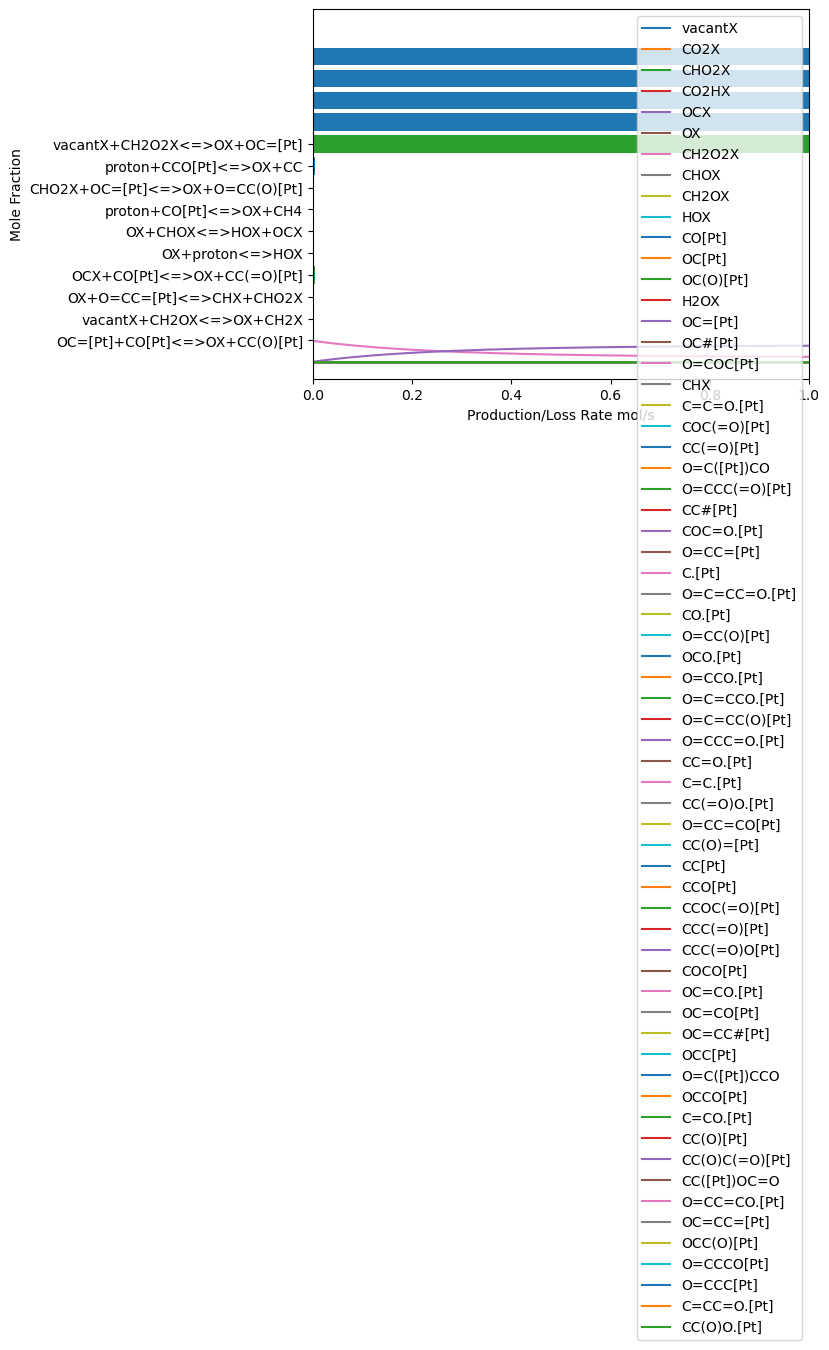

In [20]:
plotrops(ssys,"OX",1;N=10,tol=0.0)
gcf()

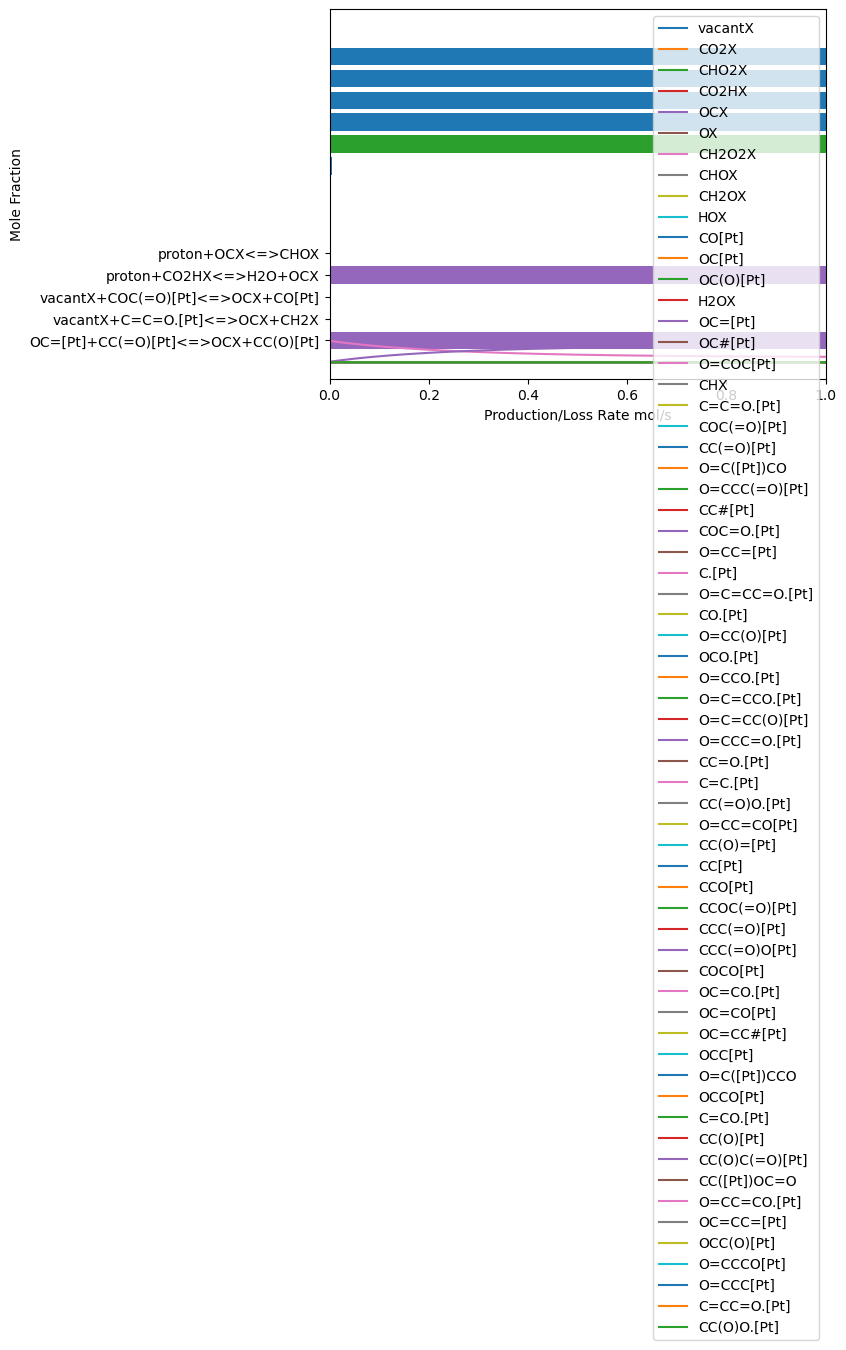

In [21]:
plotrops(ssys,"OCX",1.0e-6)
gcf()

In [22]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 6.700453386611787e9
krev = 154.2911945001599
Kc = 4.342732200835248e7
proton+CO2X<=>CO2HX
kf = 7.803841747257553e9
krev = 7.148654626970559e-10
Kc = 1.0916518078541791e19
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 3.2154148400024995e-34
Kc = 7.775046531781437e43
proton+CO2HX<=>CH2O2X
kf = 2.5e10
krev = 8.082730550170151e-23
Kc = 3.0930141546625875e32
proton+OCX<=>CHOX
kf = 2.5e10
krev = 9.19383930722573e-19
Kc = 2.71921219901589e28
proton+CHOX<=>CH2OX
kf = 2.5e10
krev = 2.4457047139990357e-18
Kc = 1.0222002622353312e28
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923385e-24
krev = 3.037156297092477e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 1.678437078622112e-22
Kc = 1.4894809176000438e32
vacantX+C=O<=>CH2OX
kf = 500114.1348800291
krev = 399.68032801417183
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 0.00010342351299484538
krev = 3.76476421238

In [23]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 6.700453386611787e9
krev = 154.2911945001599
Kc = 4.342732200835248e7
proton+CO2X<=>CO2HX
kf = 7.803841747257553e9
krev = 7.148654626970559e-10
Kc = 1.0916518078541791e19
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 3.2154148400024995e-34
Kc = 7.775046531781437e43
proton+CO2HX<=>CH2O2X
kf = 2.5e10
krev = 8.082730550170151e-23
Kc = 3.0930141546625875e32
proton+OCX<=>CHOX
kf = 2.5e10
krev = 9.19383930722573e-19
Kc = 2.71921219901589e28
proton+CHOX<=>CH2OX
kf = 2.5e10
krev = 2.4457047139990357e-18
Kc = 1.0222002622353312e28
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923385e-24
krev = 3.037156297092477e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 1.678437078622112e-22
Kc = 1.4894809176000438e32
vacantX+C=O<=>CH2OX
kf = 500114.1348800291
krev = 399.68032801417183
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 0.00010342351299484538
krev = 3.76476421238